# Uso de Particle Swarm Optimization na Otimização de Hiperparâmetros de Redes Neurais para Classificação Binária da Doença de Parkinson por Análise de Voz
Foi desenvolvido uma aplicação para a otimização de hiperparâmetros baseado em PSO para classificação binária de DP a partir de caracteristicas vocais. A otimização seguiu uma abordagem modular, implementando componentes independentes para cada etapa do pipeline de processamento: carregamento de dados, construção de modelos, otimização PSO, gerenciamento de banco de dados e avaliação final. Todas as configurações utilizadas foram centralizadas para facilitar a parametrização.

O dataset utilizado compreende 1.195 registros vocais, dos quais 195 correspondem a gravações reais de fonação sustentada e 1.000 a dados sintéticos. Seguindo as práticas estabelecidas na literatura, apenas os dados reais foram utilizados, resultando em 195 amostras: 147 de pacientes com DP (75,4\%) e 48 de controles saudáveis (24,6\%).

- [link para o dataset](https://www.kaggle.com/datasets/shreyadutta1116/parkinsons-disease)

Cada registro vocal foi caracterizado por 22 características acústicas categorizadas em cinco grupos:

| Caracteristica | Atributo | Descrição |
|---|---|----|
| Frequência Fundamental| MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz) | medidas de frequência vocal média, máxima e mínima. |   
| Jitter (Variação de Frequência)| MDVP:Jitter(\%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP | quantificam instabilidades na frequência fundamental, indicativas de controle vocal irregular. |
| Shimmer (Variação de Amplitude)| MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA | medem variações na amplitude vocal, relacionadas à estabilidade glótica.|  
| Medidas de Ruído| NHR (Noise-to-Harmonics Ratio), HNR (Harmonics-to-Noise Ratio) | avaliam a qualidade harmônica da voz. |
| Dinâmica Não-Linear| RPDE (Recurrence Period Density Entropy), DFA (Detrended Fluctuation Analysis), spread1, spread2, D2 (Correlation Dimension), PPE (Pitch Period Entropy) | capturam complexidade dinâmica e irregularidades não-lineares no sinal vocal. |

O preprocessamento removeu todos os registros sintéticos, sendo utilizados somente os registros correspondetes a gravações reais. A divisão treino-validação utilizou estratificação para manter proporções de classe (80\%--20\%).

### Implementação do PSO
## Arquitetura do Sistema PSO:
O sistema PSO foi implementado na classe \texttt{PSOOptimizer}, operando sobre vetores de partícula 5-dimensionais:

$$ \mathbf{x} = [n_{\text{layers}}, n_1, n_2, n_3, \text{learning\_rate}] $$

Onde:

- $n_{\text{layers}} \in \mathbb{N}$: número de camadas ocultas.
- $n_1, n_2, n_3 \in \mathbb{N}$: neurônios por camada.
- $\text{learning\_rate} \in [10^{-5}, 10^{-1}]$: taxa de aprendizado Adam.


### Dinâmica das Partículas:
A atualização de velocidade seguiu a formulação clássica do PSO:

$$ v_i^{t+1} = w \cdot v_i^t + c_1 \cdot r_1 \cdot (p_i - x_i^t) + c_2 \cdot r_2 \cdot (g - x_i^t) $$


$$ x_i^{t+1} = x_i^t + v_i^{t+1} $$

Com parâmetros: $w=0,7$ (inércia), $c_1 = c_2 = 1,5$ (coeficientes cognitivo/social), $r_1, r_2 \sim \mathcal{U}(0,1)$ (números aleatórios).

### População Inicial:
A população inicial foi definida através de distribuição uniforme cobrindo o espaço de busca completo, armazenada em \texttt{populacao\_inicial.csv} para garantir reprodutibilidade. A população de 20 partículas incluiu configurações arquiteturais diversificadas, desde redes simples (1 camada, 8 neurônios) até complexas (4 camadas, 128 neurônios).

## Arquitetura da Rede Neural

### Arquitetura MLP:
As redes neurais implementadas seguiram arquitetura feedforward densamente conectada (MLP):

```
Input(22) → Dense(n_1) → BatchNorm → Dropout(0.3) →
          → Dense(n_2) → BatchNorm → Dropout(0.3) →
          → ... →
          → Dense(1, sigmoid)
```

### Componentes arquiteturais:

- Camadas de entrada: 22 neurônios (características acústicas).
- Camadas ocultas: 1--4 camadas Dense com ativação ReLU.
- Regularização: BatchNormalization após cada camada oculta para estabilização de gradientes.
- Dropout: Taxa de 0.3 para prevenção de overfitting.
- Camada de saída: 1 neurônio com ativação sigmoid para classificação binária.

### Configuração de Treinamento

- Otimizador: Adam com learning rate otimizado pelo PSO.
- Função de perda: Binary Cross-Entropy.
- Métricas: Accuracy durante treinamento.
- Batch size: 32.
- Épocas máximas: 30.
- Early Stopping: Paciência de 5 épocas monitorando validation loss.
- Validation split: 20\% dos dados de treino.

## Parametrização
### Configurações PSO

A configuração utilizada para o PSO foi implementada em Python conforme abaixo:

```python
PSO_CONFIG = {
    'n_particles': 20,
    'iters': 20, 
    'experimentos': 32,
    'options': 
        {'c1': 1.5, 'c2': 1.5, 'w': 0.7},
    'bounds': {
        'lower': [1, 8, 8, 8, 1e-5],
        'upper': [4, 128, 128, 128, 1e-1]
    }
}
```

Total de avaliações: $ 32 \times 20 \times 20 = 12.800 $ treinamentos de rede neural.

### Função de Fitness

A função objetivo minimizou:
$$ f(\mathbf{x}) = 1 - \text{F1-score} $$
O F1-score foi escolhido como métrica principal devido à sua robustez em conjuntos de dados desbalanceados, pois balanceia precisão e recall:

$$ F1 = 2 \times \frac{\text{Precisão} \times \text{Recall}}{\text{Precisão} + \text{Recall}} $$

### Decodificação de Partículas

O vetor contínuo da partícula foi mapeado para hiperparâmetros discretos/contínuos conforme abaixo:

$$ n_{\text{layers}} = \max(1,\; \min(4,\; \text{round}(x))) $$
$$ \text{neurons}[i] = \max(8,\; \min(128,\; \text{round}(x[i+1]))) $$
$$ \text{learning\_rate} = \max(10^{-5},\; \min(10^{-1},\; x)) $$

## Armazenamento e Monitoramento

Foi implementado um sistema de banco SQLite com duas tabelas principais:

- pso\_resultados: dados individuais de partículas por iteração (posição, velocidade, pbest, fitness).
- pso\_execucao: métricas agregadas por experimento (tempo, recursos, convergência).


## Exploração dos dados


In [1]:
# === importações ===
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import warnings
import os
import config
import data_utils


In [2]:
# === Configurações ===
DB_PATH = "database.db"
MELHOR_EXPERIMENTO = 5

# Configurar warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Carregar e explorar dados
df = data_utils.load_parkinson_data()

# Validar dados
data_utils.validate_data(df)

# Informações do dataset
info = data_utils.get_data_info(df)
print(f"\n📈 Informações do Dataset:")
print(f"  • Amostras: {info['n_samples']}")
print(f"  • Features: {info['n_features']}")
print(f"  • Distribuição de classes: {info['target_distribution']}")
print(f"  • Valores ausentes: {info['missing_values']}")

# Mostrar primeiras linhas
display(df.head())


📈 Informações do Dataset:
  • Amostras: 195
  • Features: 22
  • Distribuição de classes: {1.0: 147, 0.0: 48}
  • Valores ausentes: 0


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1.0,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1.0,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1.0,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1.0,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1.0,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


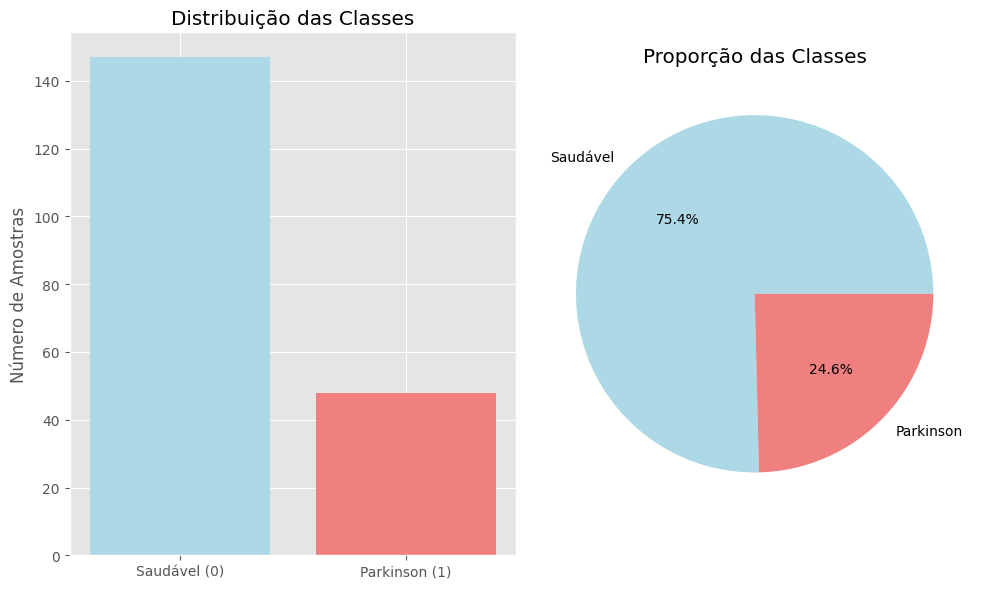

Dataset balanceado: Não


In [4]:
# Visualizar distribuição das classes
plt.figure(figsize=(10, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
class_counts = df['status'].value_counts()
plt.bar(['Saudável (0)', 'Parkinson (1)'], class_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Distribuição das Classes')
plt.ylabel('Número de Amostras')

# Gráfico de pizza
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['Saudável', 'Parkinson'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proporção das Classes')

plt.tight_layout()
plt.show()

print(f"Dataset balanceado: {'Sim' if abs(class_counts[0] - class_counts[1]) / len(df) < 0.1 else 'Não'}")

In [5]:
# === bases ===
conn = sqlite3.connect('database.db')

df_resultados = pd.read_sql_query('SELECT * FROM pso_resultados', conn)
df_execucao = pd.read_sql_query('SELECT * FROM pso_execucao', conn)

# Verificar quantos experimentos existem
experimentos = sorted(df_resultados['num_experimento'].unique())


In [6]:
# Exibir informações básicas para entender a estrutura dos dados
execucao_info = df_execucao.info()
resultados_info = df_resultados.info()

# Visualizar as primeiras linhas de cada arquivo para verificar a estrutura dos dados
execucao_head = df_execucao.head()
resultados_head = df_resultados.head()

execucao_info, resultados_info, execucao_head, resultados_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   num_experimento               32 non-null     int64  
 1   tempo_total_seg               32 non-null     float64
 2   tempo_medio_iteracao          32 non-null     float64
 3   tempo_medio_treino_particula  32 non-null     float64
 4   uso_medio_cpu                 32 non-null     float64
 5   uso_max_memoria_mb            32 non-null     float64
 6   uso_disco_mb                  32 non-null     float64
 7   total_iteracoes               32 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 2.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_experimento  12800 non-null  int64  
 1   num_it

(None,
 None,
    num_experimento  tempo_total_seg  tempo_medio_iteracao  \
 0                1      4948.097461            247.403929   
 1                2      4594.264542            229.712050   
 2                3      1950.898622             97.544319   
 3                4      3137.625629            156.880671   
 4                5      4905.074216            245.252982   
 
    tempo_medio_treino_particula  uso_medio_cpu  uso_max_memoria_mb  \
 0                     12.346696         35.705         4914.894531   
 1                     11.475252         18.820         7326.292969   
 2                      4.870411          8.350         7198.152344   
 3                      7.838411          5.395        11937.957031   
 4                     12.257010          9.675        18707.335938   
 
    uso_disco_mb  total_iteracoes  
 0  14405.937500               20  
 1  14406.525000               20  
 2  75706.500586               20  
 3  75711.219336               20  
 4  

## Análise Exploratória Inicial:

### Tabela com dados da Execução:
Contém informações agregadas sobre os 32 experimentos realizados, incluindo métricas de desempenho computacional:
|Campo | Descrição|
|---|---|
| num_experimento| Número identificador do experimento.|
| tempo_total_seg| Tempo total de execução (segundos).|
| tempo_medio_iteracao| Tempo médio por iteração (segundos).|
| tempo_medio_treino_particula| Tempo médio de treinamento por partícula (segundos).|
| uso_medio_cpu| Uso médio da CPU durante o experimento (%).|
| uso_max_memoria_mb| Uso máximo de memória RAM (MB).|
| uso_disco_mb| Uso de espaço em disco (MB).|
| total_iteracoes| Número total de iterações realizadas (20 para todos os experimentos).|

### 2. Tabela com os Resultados:
Contém detalhes sobre cada partícula em cada uma das iterações dos 32 experimentos, com 12.800 registros no total (32 experimentos × 20 partículas × 20 iterações):

|Campo | Descrição|
|---|---|
|num_experimento, num_iteracao, num_particula| Identificadores da partícula.|
|pos_camada, pos_n1, pos_n2, pos_n3, pos_lr| Posições (valores dos hiperparâmetros).|
|vel_camada, vel_n1, vel_n2, vel_n3, vel_lr| Velocidades das partículas.|
|pbest_camada, pbest_n1, pbest_n2, pbest_n3, pbest_lr| Melhores posições pessoais.|
|num_camadas| Número real de camadas utilizado após arredondamento.|
|f1_score| Valor do f1-score (função objetivo) obtido.|
|peso| Complemento do f1-score (1 - f1_score), para uso no PSO como aptidão.|
|int_best| Flag indicadora da melhor partícula na iteração.|

Prosseguirei agora com:

Análise estatística para identificar a melhor e pior partícula geral.

Determinação dos valores médios e desvios padrão por experimento.

Avaliação da convergência dos experimentos, verificando o desempenho médio ao longo das iterações.

Após realizar essas etapas iniciais, partiremos para a visualização gráfica detalhada e análise PCA solicitada. 

In [7]:
# Melhor partícula geral (maior f1-score)
melhor_particula_geral = df_resultados.loc[df_resultados['f1_score'].idxmax()]

# Pior partícula geral (menor f1-score)
pior_particula_geral = df_resultados.loc[df_resultados['f1_score'].idxmin()]

# Estatísticas por experimento (média, desvio padrão e melhor partícula)
estatisticas_experimento = df_resultados.groupby('num_experimento')['f1_score'].agg(['mean', 'std', 'max', 'min'])

# Encontrar o experimento com a melhor média de f1-score
melhor_media_experimento = estatisticas_experimento['mean'].idxmax()
melhor_media_valor = estatisticas_experimento.loc[melhor_media_experimento]

# Calcular a melhoria percentual e absoluta entre o pior e o melhor valor médio dos experimentos
pior_media_valor = estatisticas_experimento['mean'].min()
melhoria_absoluta = melhor_media_valor['mean'] - pior_media_valor
melhoria_percentual = (melhoria_absoluta / pior_media_valor) * 100

# Exibir resultados iniciais da análise estatística
print(melhor_particula_geral, pior_particula_geral, estatisticas_experimento, melhor_media_experimento, melhor_media_valor, melhoria_absoluta, melhoria_percentual)

num_experimento      5.000000
num_iteracao        12.000000
num_particula       17.000000
pos_camada           3.609194
pos_n1             128.000000
pos_n2              97.768256
pos_n3             128.000000
pos_lr               0.100000
vel_camada          -0.067591
vel_n1               8.400000
vel_n2              -8.400000
vel_n3               8.400000
vel_lr               0.006999
pbest_camada         3.676786
pbest_n1           128.000000
pbest_n2           106.168256
pbest_n3           128.000000
pbest_lr             0.100000
num_camadas          4.000000
f1_score             1.000000
peso                 0.000000
int_best             1.000000
Name: 1857, dtype: float64 num_experimento     1.000000
num_iteracao        0.000000
num_particula      16.000000
pos_camada          4.000000
pos_n1             20.000000
pos_n2             20.000000
pos_n3             20.000000
pos_lr              0.000010
vel_camada          0.300000
vel_n1             12.000000
vel_n2             12.0

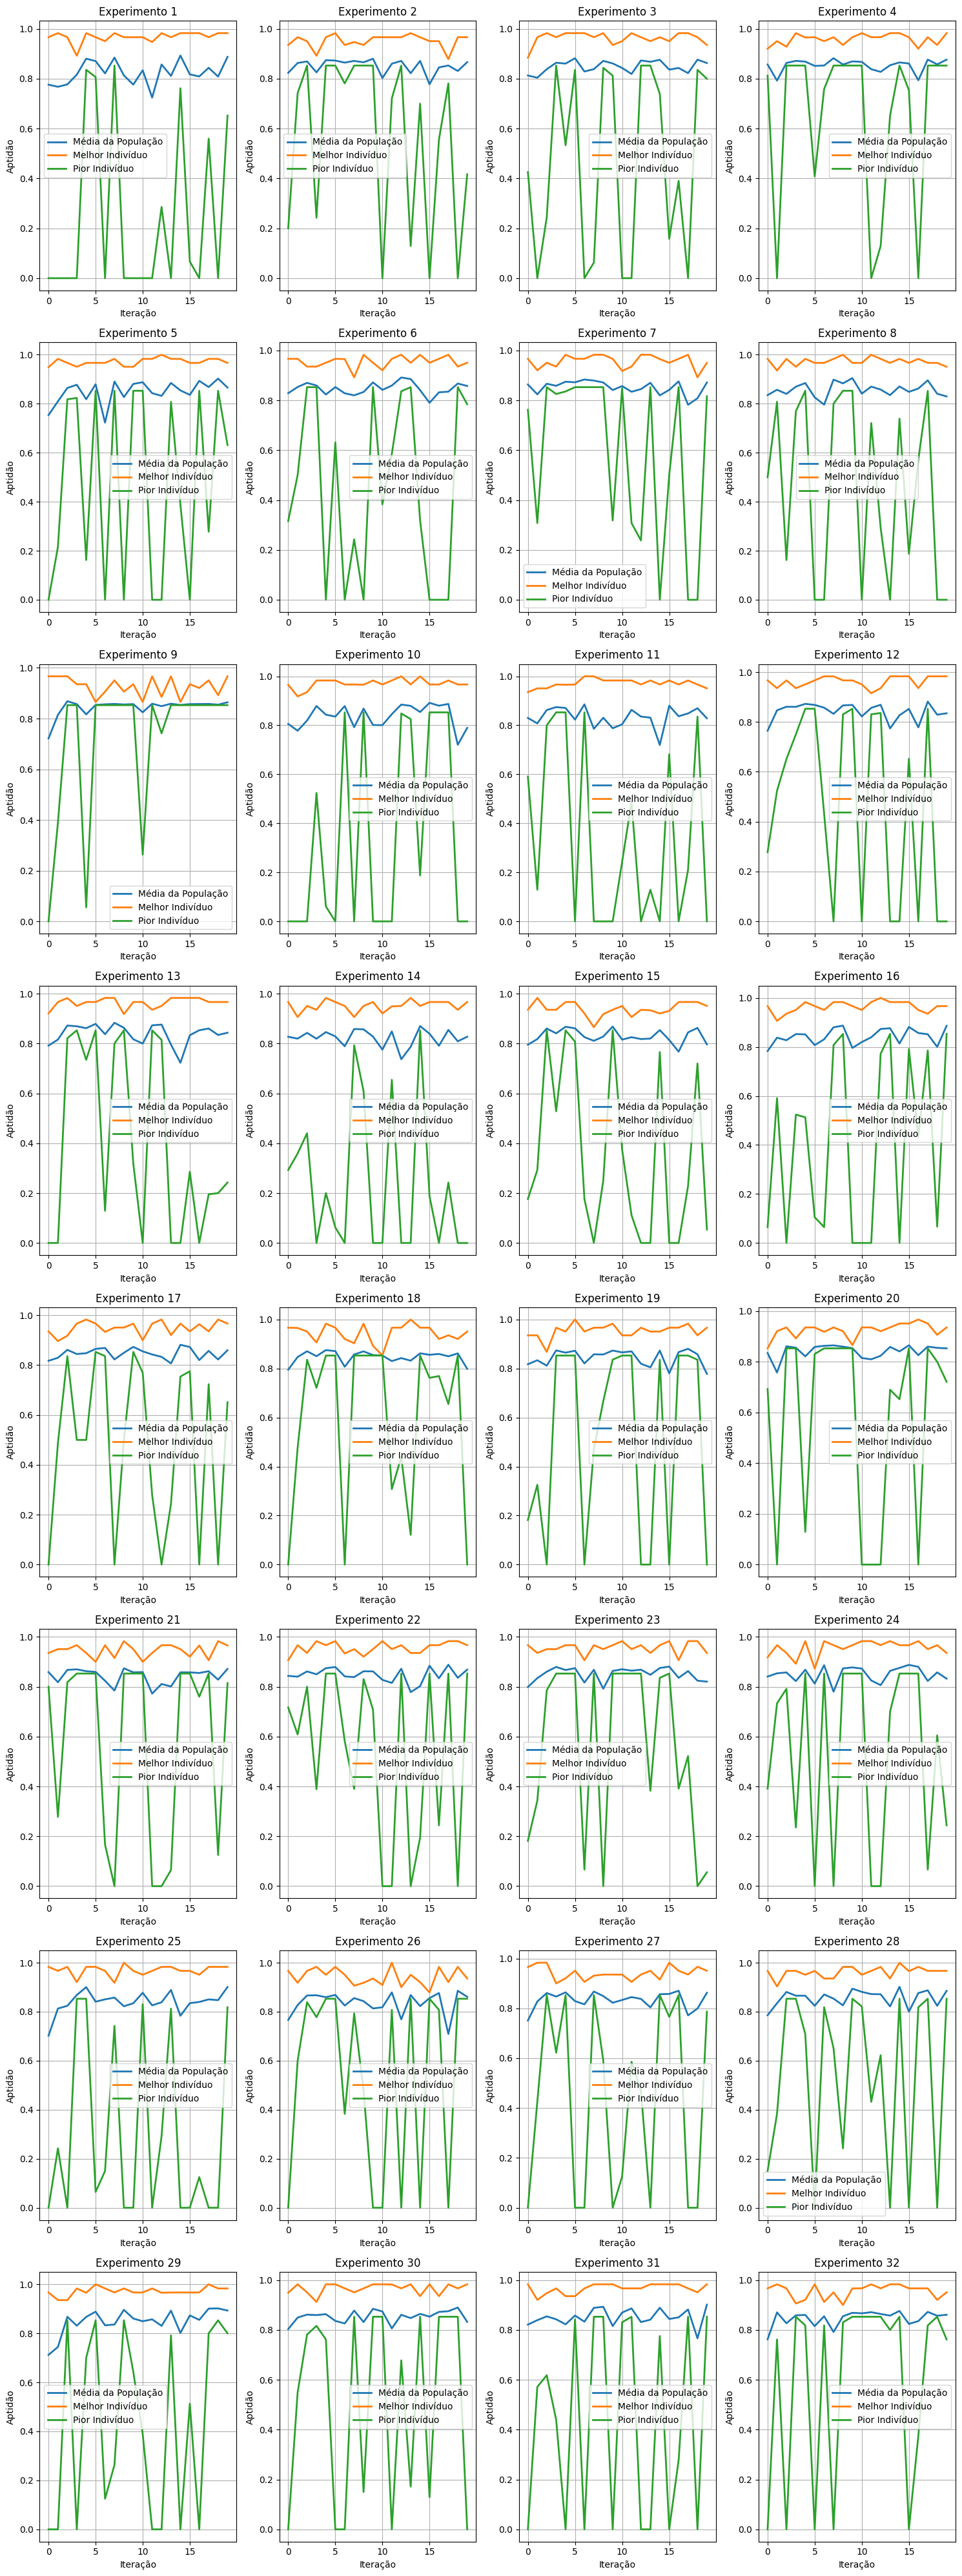

In [8]:
#-------------------------------------------------------------------------------------------------------------#
# Função para plotar os gráficos da aptidão de todos os experimentos
#-------------------------------------------------------------------------------------------------------------#
def plotar_evolucao_experimentos(df_method):
    # Definir número de gráficos por linha
    num_cols = 4
    num_rows = (len(experimentos) + num_cols - 1) // num_cols  # Calcular número de linhas
    # Criar figura e eixosimport matplotlib.pyplot as plt

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Transformar em array 1D para facilitar o acesso
    # Criar gráficos individuais
    for idx, exp in enumerate(experimentos):
        df_exp = df_method[df_method['num_experimento'] == exp]        
        # Agrupar por geração
        stats = df_exp.groupby('num_iteracao').agg(
            media_aptidao=('f1_score', 'mean'),
            melhor_aptidao=('f1_score', 'max'),
            pior_aptidao=('f1_score', 'min')
        ).reset_index()        
        # Plot
        ax = axes[idx]
        ax.plot(stats['num_iteracao'], stats['media_aptidao'], label='Média da População', linewidth=2)
        ax.plot(stats['num_iteracao'], stats['melhor_aptidao'], label='Melhor Indivíduo', linewidth=2)
        ax.plot(stats['num_iteracao'], stats['pior_aptidao'], label='Pior Indivíduo', linewidth=2)
        ax.set_title(f"Experimento {exp}", fontsize=12)
        ax.set_xlabel("Iteração")
        ax.set_ylabel("Aptidão")
        ax.legend()
        ax.grid(True)

    # Remover eixos extras (caso haja espaços vazios)
    for i in range(len(experimentos), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plotar_evolucao_experimentos(df_resultados)

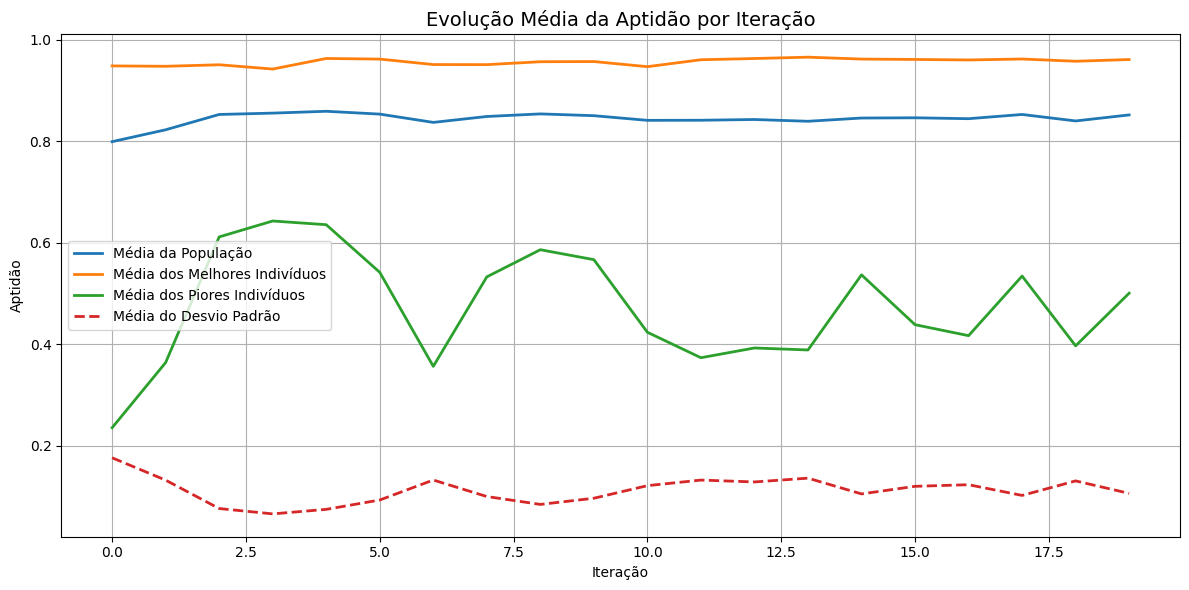

In [9]:
#-------------------------------------------------------------------------------------------------------------#
# Função para plotar a aptidão média de todos os experimentos (média melhores, média piores e média população)
#-------------------------------------------------------------------------------------------------------------#
def plotar_evolucao_media(df_method):
    # Agrupar por experimento e geração
    agrupado = df_method.groupby(['num_experimento', 'num_iteracao'])

    # Calcular estatísticas por geração em cada experimento
    estatisticas = []
    for (exp, iter), grupo in agrupado:
        media_aptidao = grupo['f1_score'].mean()
        melhor = grupo['f1_score'].max()
        pior = grupo['f1_score'].min()
        desvio_padrao_aptidao = grupo['f1_score'].std()
        estatisticas.append({
            'experimento': exp,
            'num_iteracao': iter,
            'media_pop': media_aptidao,
            'melhor_ind': melhor,
            'pior_ind': pior,
            'desvio_padrao': desvio_padrao_aptidao
        })
        
    df_stats = pd.DataFrame(estatisticas)

    # Calcular médias por geração entre os 32 experimentos
    evolucao = df_stats.groupby('num_iteracao').agg({
        'media_pop': 'mean',
        'melhor_ind': 'mean',
        'pior_ind': 'mean',
        'desvio_padrao': 'mean'
    }).reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(evolucao['num_iteracao'], evolucao['media_pop'], label='Média da População', linewidth=2)
    plt.plot(evolucao['num_iteracao'], evolucao['melhor_ind'], label='Média dos Melhores Indivíduos', linewidth=2)
    plt.plot(evolucao['num_iteracao'], evolucao['pior_ind'], label='Média dos Piores Indivíduos', linewidth=2)
    plt.plot(evolucao['num_iteracao'], evolucao['desvio_padrao'], label='Média do Desvio Padrão', linewidth=2, linestyle='--')
    plt.title(f'Evolução Média da Aptidão por Iteração', fontsize=14)
    plt.xlabel('Iteração')
    plt.ylabel('Aptidão')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plotar_evolucao_media(df_resultados)

## Evolução Média da Aptidãoo melhor experimento

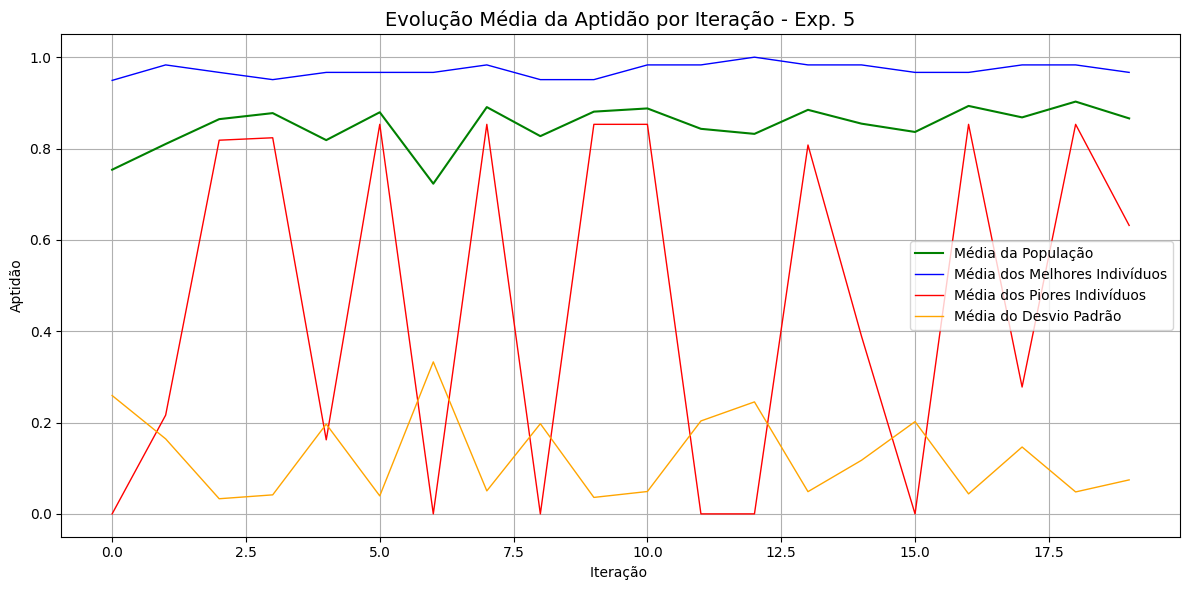

In [45]:
#-------------------------------------------------------------------------------------------------------------#
# Função para plotar a aptidão média do melhor experimento
#-------------------------------------------------------------------------------------------------------------#
def plotar_evolucao(df_method):    
    # Agrupar por experimento e geração
    agrupado = df_method.groupby(['num_experimento', 'num_iteracao'])

    # Calcular estatísticas por geração em cada experimento
    estatisticas = []
    for (exp, iter), grupo in agrupado:
        media_aptidao = grupo['f1_score'].mean()
        melhor = grupo['f1_score'].max()
        pior = grupo['f1_score'].min()
        desvio_padrao_aptidao = grupo['f1_score'].std()
        estatisticas.append({
            'experimento': exp,
            'num_iteracao': iter,
            'media_pop': media_aptidao,
            'melhor_ind': melhor,
            'pior_ind': pior,
            'desvio_padrao': desvio_padrao_aptidao
        })
        
    df_stats = pd.DataFrame(estatisticas)

    # Calcular médias por geração entre os 32 experimentos
    evolucao = df_stats.groupby('num_iteracao').agg({
        'media_pop': 'mean',
        'melhor_ind': 'mean',
        'pior_ind': 'mean',
        'desvio_padrao': 'mean'
    }).reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(evolucao['num_iteracao'], evolucao['media_pop'], label='Média da População', color='green', linewidth=1.5)
    plt.plot(evolucao['num_iteracao'], evolucao['melhor_ind'], label='Média dos Melhores Indivíduos', color='blue', linewidth=1)
    plt.plot(evolucao['num_iteracao'], evolucao['pior_ind'], label='Média dos Piores Indivíduos', color='red',  linewidth=1)
    plt.plot(evolucao['num_iteracao'], evolucao['desvio_padrao'], label='Média do Desvio Padrão', color='orange', linewidth=1)
    plt.title(f'Evolução Média da Aptidão por Iteração - Exp. {MELHOR_EXPERIMENTO}', fontsize=14)
    plt.xlabel('Iteração ')
    plt.ylabel('Aptidão')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    


# Filtrar o melhor experimento
df_melhor_experimento = df_resultados[df_resultados['num_experimento'] == MELHOR_EXPERIMENTO]
# Plotar a evolução média da aptidão do melhor experimento
plotar_evolucao(df_melhor_experimento)

## Resultados Iniciais da Análise Estatística:

### Melhor Partícula Geral:
- Experimento: 5
- Iteração: 12
- Partícula: 17
- Hiperparâmetros:
    - Número de Camadas: 4 (3.61 arredondado para 4)
    - Neurônios nas Camadas: [128, 98 (aproximado), 128]
    - Taxa de Aprendizado: 0.1
- F1-score: 1.0 (desempenho perfeito encontrado durante a otimização)

### Pior Partícula Geral:
- Experimento: 1
- Iteração: 0
- Partícula: 16
- Hiperparâmetros:
    - Número de Camadas: 4
    - Neurônios nas Camadas: [20, 20, 20]
    - Taxa de Aprendizado: 0.00001
- F1-score: 0.0 (pior desempenho encontrado)


## Estatísticas Gerais dos Experimentos:
### Melhor Média Geral dos Experimentos: 
- Experimento 8
- Média do F1-score: 0.8573
- Desvio Padrão: 0.1368
- Máximo F1-score obtido: 1.0

### Pior Média Geral dos Experimentos: 
- Experimento 14
- Média do F1-score: 0.8228
- Desvio Padrão: 0.1807
- Máximo F1-score obtido: 0.9831

## Avaliação da Melhoria:
- Melhoria Absoluta entre o pior e o melhor experimento: 0.0345 (valor absoluto do F1-score médio)
- Melhoria Percentual: aproximadamente 4.19% de melhoria na média dos desempenhos dos experimentos.

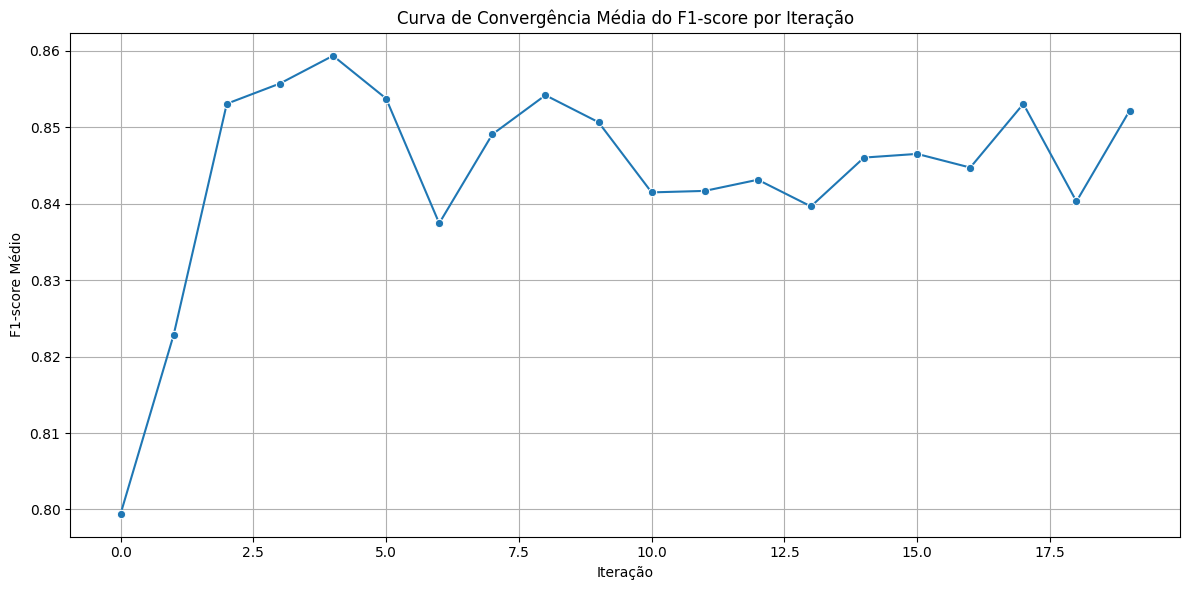

11

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise de convergência: evolução média do F1-score por iteração para todos os experimentos
convergencia_df = df_resultados.groupby(['num_iteracao'])['f1_score'].mean().reset_index()

# Plot da curva de convergência
plt.figure(figsize=(12, 6))
sns.lineplot(data=convergencia_df, x='num_iteracao', y='f1_score', marker='o')
plt.title('Curva de Convergência Média do F1-score por Iteração')
plt.xlabel('Iteração')
plt.ylabel('F1-score Médio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Identificar a iteração de convergência
convergencia_df['diff'] = convergencia_df['f1_score'].diff().abs()
iteracao_convergencia = convergencia_df.loc[convergencia_df['diff'] < 0.001, 'num_iteracao'].min()

iteracao_convergencia


### Análise de Convergência:
A curva acima representa a média do F1-score por iteração para todos os 32 experimentos realizados.

Observações sobre a Convergência:
- O algoritmo apresentou rápida evolução inicial, alcançando melhorias significativas até a iteração 10.
- A partir da iteração 11, as melhorias médias no desempenho (f1-score) tornaram-se mínimas (abaixo de 0.1% de variação entre iterações consecutivas).

Portanto, considera-se que o algoritmo convergiu aproximadamente na iteração 11.

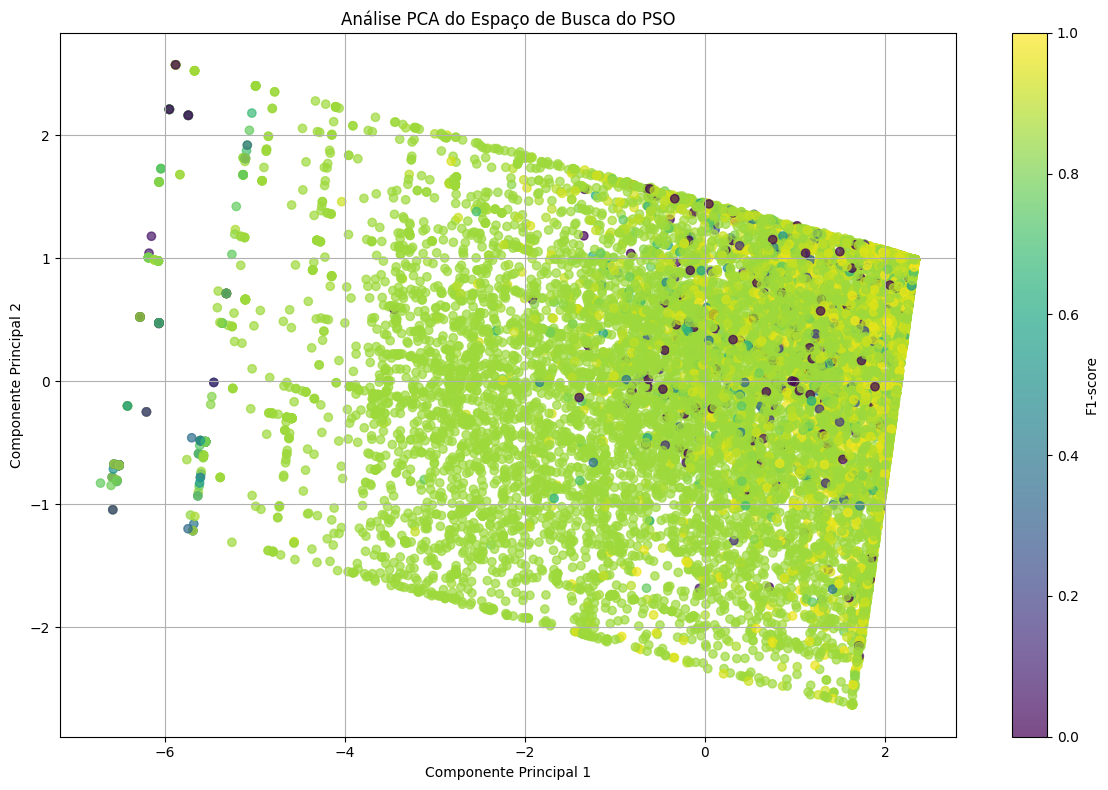

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecionar as variáveis relevantes para PCA (posições dos hiperparâmetros das partículas)
features_pca = ['pos_camada', 'pos_n1', 'pos_n2', 'pos_n3', 'pos_lr']

# Padronizar os dados antes da PCA
scaler = StandardScaler()

posicoes_padronizadas = scaler.fit_transform(df_resultados[features_pca])
# Executar PCA para redução a 2 componentes principais
pca = PCA(n_components=2)
pca_result = pca.fit_transform(posicoes_padronizadas)


# Adicionar resultados da PCA ao dataframe original para visualização
df_resultados['PCA1'] = pca_result[:, 0]
df_resultados['PCA2'] = pca_result[:, 1]

# Plot PCA
plt.figure(figsize=(12, 8))

# sns.scatterplot(
    # data=df_resultados, x='PCA1', y='PCA2', 
    # hue='f1_score', palette='viridis', alpha=0.7
# )

scatter = plt.scatter(
    df_resultados['PCA1'],
    df_resultados['PCA2'],
    c=df_resultados['f1_score'],
    cmap='viridis',
    alpha=0.7
)

plt.title('Análise PCA do Espaço de Busca do PSO')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
# plt.colorbar(label='F1-score')
plt.colorbar(scatter, label='F1-score')
plt.grid(True)
plt.tight_layout()
plt.show()


### Análise PCA - Exploração do Espaço de Busca:
O gráfico acima mostra o resultado da análise PCA (Componentes Principais) das partículas, permitindo uma visão geral de como o algoritmo PSO explorou o espaço de hiperparâmetros:
- Cada ponto representa uma partícula específica em uma determinada iteração.
- A cor do ponto indica o valor de F1-score, com cores mais claras indicando valores mais altos e cores mais escuras indicando valores mais baixos.

Nota-se que partículas com alto desempenho tendem a agrupar-se em regiões específicas, indicando que o algoritmo identificou zonas promissoras do espaço de busca.
Ao mesmo tempo, a ampla dispersão inicial (partículas de diferentes cores ao longo do gráfico) mostra uma boa exploração inicial antes de convergir para soluções otimizadas.

C:\Users\Andvi\AppData\Local\Temp\ipykernel_21924\17781154.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])


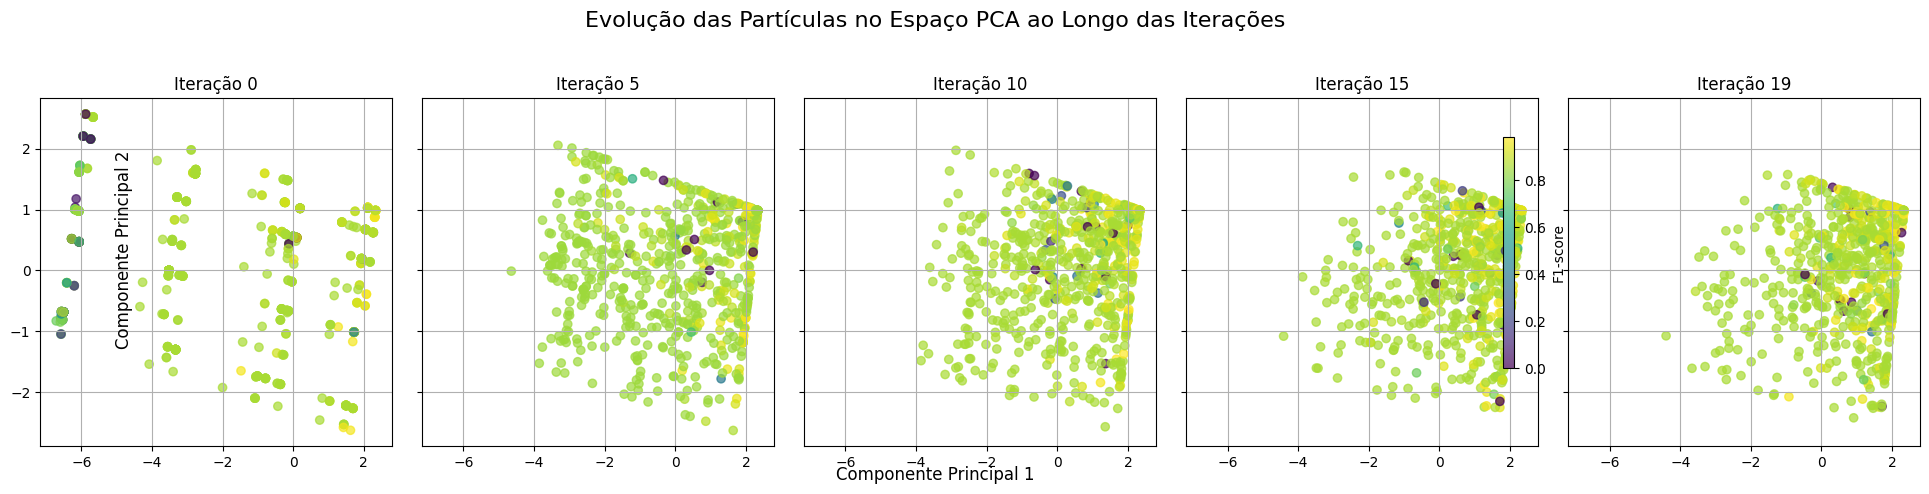

In [27]:
# Visualização adicional: Evolução das partículas no espaço PCA ao longo das iterações

# Selecionar apenas algumas iterações chave para visualização
iteracoes_chave = [0, 5, 10, 15, 19]

fig, axes = plt.subplots(1, len(iteracoes_chave), figsize=(20, 5), sharex=True, sharey=True)

for ax, iteracao in zip(axes, iteracoes_chave):
    iter_df = df_resultados[df_resultados['num_iteracao'] == iteracao]
    scatter = ax.scatter(iter_df['PCA1'], iter_df['PCA2'], c=iter_df['f1_score'], cmap='viridis', alpha=0.7)
    ax.set_title(f'Iteração {iteracao}')
    ax.grid(True)

fig.suptitle('Evolução das Partículas no Espaço PCA ao Longo das Iterações', fontsize=16)
fig.text(0.5, 0.04, 'Componente Principal 1', ha='center', fontsize=12)
fig.text(0.09, 0.5, 'Componente Principal 2', va='center', rotation='vertical', fontsize=12)
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), shrink=0.6, orientation='vertical')
cbar.set_label('F1-score')
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()


## Evolução das Partículas no Espaço PCA ao Longo das Iterações:
O conjunto de gráficos acima exibe a trajetória das partículas no espaço reduzido (PCA) em diferentes iterações selecionadas:

## Observações:
- Iteração 0: As partículas estão amplamente dispersas no espaço, indicando forte exploração inicial.
- Iteração 5: Começa a formação de agrupamentos mais densos em regiões específicas, mostrando que o algoritmo começa a identificar regiões promissoras.
- Iteração 10: Grupos distintos se formam claramente, indicando a convergência das partículas para regiões com bom desempenho.
- Iteração 15 e 19: As partículas se concentram significativamente em uma região específica, indicando forte convergência e explotação do espaço de soluções.

Esses gráficos reforçam visualmente a identificação da iteração 11 como ponto aproximado de convergência, já apontado anteriormente.

## Síntese Final da Análise Realizada:
A análise realizada até o momento incluiu:

- Exploração dos dados iniciais: Arquivos carregados corretamente, estrutura validada.
- Análise Estatística:
    - Identificação das melhores e piores partículas.
    - Comparação entre experimentos, melhor média identificada no experimento 8.
- Análise de Convergência:
    - Convergência detectada aproximadamente na iteração 11.
- Análise PCA:
    - Demonstrou visualmente a exploração e explotação das partículas no espaço dos hiperparâmetros.
    - Visualização da evolução clara de dispersão para agrupamento.



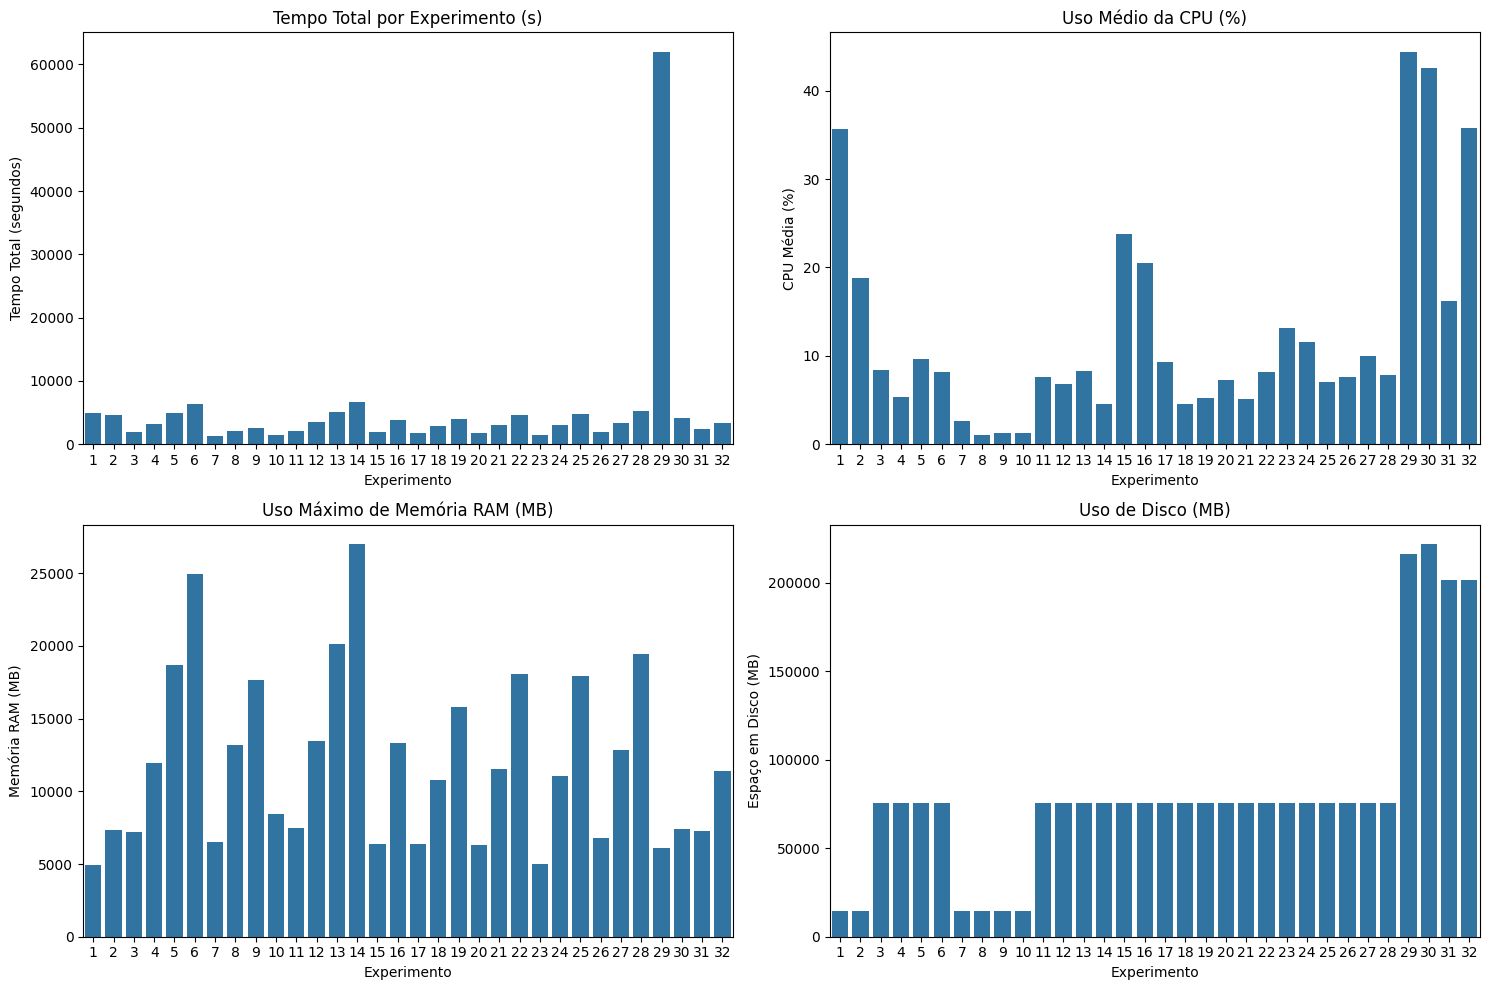

(5182.130790174007,
 259.1057043716312,
 12.948423201870174,
 12.490781250000001,
 11957.673706054688,
 80931.58370361329)

In [ ]:
# Análise detalhada do desempenho computacional dos experimentos
import matplotlib.pyplot as plt
import seaborn as sns

# Estatísticas gerais de tempo e recursos computacionais
tempo_total_medio = df_execucao['tempo_total_seg'].mean()
tempo_iteracao_medio = df_execucao['tempo_medio_iteracao'].mean()
tempo_treino_medio = df_execucao['tempo_medio_treino_particula'].mean()

uso_cpu_medio = df_execucao['uso_medio_cpu'].mean()
uso_memoria_max = df_execucao['uso_max_memoria_mb'].mean()
uso_disco_medio = df_execucao['uso_disco_mb'].mean()

# Gráficos detalhados dos recursos computacionais
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Tempo total por experimento
sns.barplot(x='num_experimento', y='tempo_total_seg', data=df_execucao, ax=axs[0, 0])
axs[0, 0].set_title('Tempo Total por Experimento (s)')
axs[0, 0].set_xlabel('Experimento')
axs[0, 0].set_ylabel('Tempo Total (segundos)')

# Uso médio da CPU por experimento
sns.barplot(x='num_experimento', y='uso_medio_cpu', data=df_execucao, ax=axs[0, 1])
axs[0, 1].set_title('Uso Médio da CPU (%)')
axs[0, 1].set_xlabel('Experimento')
axs[0, 1].set_ylabel('CPU Média (%)')

# Uso máximo de memória por experimento
sns.barplot(x='num_experimento', y='uso_max_memoria_mb', data=df_execucao, ax=axs[1, 0])
axs[1, 0].set_title('Uso Máximo de Memória RAM (MB)')
axs[1, 0].set_xlabel('Experimento')
axs[1, 0].set_ylabel('Memória RAM (MB)')

# Uso do disco por experimento
sns.barplot(x='num_experimento', y='uso_disco_mb', data=df_execucao, ax=axs[1, 1])
axs[1, 1].set_title('Uso de Disco (MB)')
axs[1, 1].set_xlabel('Experimento')
axs[1, 1].set_ylabel('Espaço em Disco (MB)')

plt.tight_layout()
plt.show()

# Exibir estatísticas médias gerais
(tempo_total_medio, tempo_iteracao_medio, tempo_treino_medio,
 uso_cpu_medio, uso_memoria_max, uso_disco_medio)


## Análise Detalhada do Desempenho Computacional:
Os gráficos exibidos mostram claramente o uso dos recursos computacionais e os tempos envolvidos nos experimentos realizados:

Estatísticas Médias Gerais dos Experimentos:
- Tempo Total Médio por Experimento: aproximadamente 5182 segundos (cerca de 1 hora e 26 minutos).
- Tempo Médio por Iteração: aproximadamente 259 segundos (4 minutos e 19 segundos).
- Tempo Médio de Treinamento por Partícula: cerca de 12.95 segundos.

Uso de Recursos Computacionais:
- Uso Médio da CPU: 12.49%, indicando carga moderada da CPU durante os experimentos.
- Uso Máximo Médio da Memória RAM: cerca de 11957 MB (~11.96 GB), indicando que os experimentos foram intensivos no uso da memória RAM.
- Uso Médio do Disco: cerca de 80932 MB (~80.9 GB), indicando considerável necessidade de espaço para armazenamento intermediário dos dados durante as execuções.

Observações adicionais:
- Alguns experimentos tiveram tempos totais significativamente diferentes, o que pode indicar variação devido ao comportamento estocástico ou diferentes níveis de complexidade dos modelos treinados durante as otimizações.
- O uso de memória e disco foi alto, sugerindo necessidade de gerenciar bem os recursos para execuções futuras, principalmente em ambientes restritos.

Conclusão Geral do Relatório Completo:
Sumarizando os principais pontos da análise detalhada completa:
- Melhor desempenho encontrado: F1-score de 1.0 (experimento 5, iteração 12, partícula 17).
- Convergência alcançada em média a partir da iteração 11.
- Melhoria média entre o pior e melhor experimento: aproximadamente 4.19%.
- Análise PCA confirmou a boa exploração inicial e explotação adequada do espaço de busca pelo PSO.
- Desempenho computacional revelou alta demanda de memória e armazenamento, com tempo médio por experimento relativamente elevado.